**importing the libraries**

In [29]:
import pandas as pd
import numpy as np
import torch 
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

**loading the data**

In [2]:
df = pd.read_csv('/content/rnn_dataset.csv')

In [3]:
df['Datetime'] = pd.to_datetime(df['Datetime'])
df

,Datetime,PJMW_MW
0,2002-12-31 01:00:00,5077.0
1,2002-12-31 02:00:00,4939.0
2,2002-12-31 03:00:00,4885.0
3,2002-12-31 04:00:00,4857.0
4,2002-12-31 05:00:00,4930.0
...,...,...
143201,2018-01-01 20:00:00,8401.0
143202,2018-01-01 21:00:00,8373.0
143203,2018-01-01 22:00:00,8238.0
143204,2018-01-01 23:00:00,7958.0


In [4]:
#set datetime column as index of dataframe and sort in ascending order
df = df.set_index('Datetime').sort_index()
df

,PJMW_MW
Datetime,
2002-04-01 01:00:00,4374.0
2002-04-01 02:00:00,4306.0
2002-04-01 03:00:00,4322.0
2002-04-01 04:00:00,4359.0
2002-04-01 05:00:00,4436.0
...,...
2018-08-02 20:00:00,6545.0
2018-08-02 21:00:00,6496.0
2018-08-02 22:00:00,6325.0


**setting the target variable**

In [5]:
target = df['PJMW_MW'].values
target

array([4374., 4306., 4322., ..., 6325., 5892., 5489.])

**standardising the variable**

In [6]:
target = (target - target.mean()) / target.std()

**defining the RNN model**

In [8]:
# Define RNN model
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.hidden_size)
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])
        return out


In [9]:
# Set hyperparameters
seq_len = 100
input_size = 1
hidden_size = 32
output_size = 1

**splitting the data**

In [11]:
def data_form(target, seq_len):
  data = target[:(len(target) - seq_len)]
  train, test = train_test_split(data, test_size = 0.3, random_state=24, shuffle= False)
  val, test1 = train_test_split(test, test_size = 0.5, random_state=24, shuffle= False)
  return train,val,test1

In [12]:
train_data, val_data, test_data = data_form(target, 100)

**creating the data with given sequence**

In [13]:
def create_sequences(data):
    X = []
    y = []
    for i in range(len(data) - seq_len):
        seq = data[i:i+seq_len]
        label = data[i+seq_len]
        X.append(seq.reshape(-1, 1))
        y.append(label)
    X = np.array(X)
    y = np.array(y)
    return X, y

In [15]:
def dataset(train_data, val_data, test_data):
  x_train, y_train = create_sequences(train_data)
  x_train = torch.from_numpy(x_train).float()
  y_train = torch.from_numpy(y_train.reshape(-1,1)).float()
  x_val, y_val = create_sequences(val_data)
  x_val = torch.from_numpy(x_val).float()
  y_val = torch.from_numpy(y_val.reshape(-1,1)).float()
  x_test, y_test = create_sequences(test_data)
  x_test = torch.from_numpy(x_test).float()
  y_test = torch.from_numpy(y_test.reshape(-1,1)).float()
  
  return x_train, y_train, x_val, y_val, x_test, y_test

In [16]:
x_train, y_train, x_val, y_val, x_test, y_test = dataset(train_data, val_data, test_data)

In [17]:
train_dataset = torch.utils.data.TensorDataset(x_train, y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size= 64)

**assigning the model**

In [18]:
model1 = RNN(input_size, hidden_size, output_size) 

In [19]:
learning_rate = 0.0001
num_epochs = 10

In [20]:
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model1.parameters(), lr= learning_rate)

**training the model**

In [21]:
# Train the model
train_los_list = []
val_los_list =[]
for epoch in range(num_epochs):
    for i, (X_batch, y_batch) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model1(X_batch)
        loss = criterion(outputs.squeeze(), y_batch)
        loss.backward()
        optimizer.step()
    train_los_list.append(loss.item())    
    model1.eval()
    val_outputs = model1(x_val)
    val_loss = criterion(val_outputs, y_val)
    val_los_list.append(val_loss.item())
        #if i % 10 == 0:
    print(f"Epoch {epoch+1}/{num_epochs}, Batch {i+1}/{len(train_loader)}, train Loss: {loss.item():.4f}, val Loss: {val_loss.item():.4f}")

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64, 1])) that is different to the input size (torch.Size([64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([42, 1])) that is different to the input size (torch.Size([42])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/10, Batch 1564/1564, train Loss: 0.6671, val Loss: 0.5403
Epoch 2/10, Batch 1564/1564, train Loss: 0.6608, val Loss: 0.5015
Epoch 3/10, Batch 1564/1564, train Loss: 0.6509, val Loss: 0.4915
Epoch 4/10, Batch 1564/1564, train Loss: 0.6406, val Loss: 0.4916
Epoch 5/10, Batch 1564/1564, train Loss: 0.6350, val Loss: 0.4842
Epoch 6/10, Batch 1564/1564, train Loss: 0.6359, val Loss: 0.4623
Epoch 7/10, Batch 1564/1564, train Loss: 0.6349, val Loss: 0.4494
Epoch 8/10, Batch 1564/1564, train Loss: 0.6339, val Loss: 0.4422
Epoch 9/10, Batch 1564/1564, train Loss: 0.6332, val Loss: 0.4375
Epoch 10/10, Batch 1564/1564, train Loss: 0.6327, val Loss: 0.4342


**plotting the training and validation curve**

Text(0.5, 1.0, 'training loss')

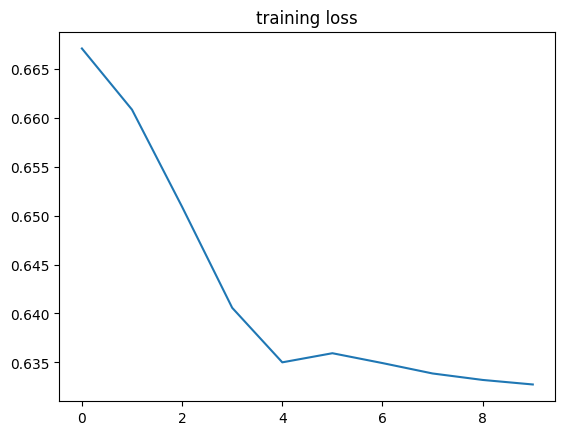

In [31]:
import matplotlib.pyplot as plt

plt.plot(range(num_epochs),train_los_list, label = 'training loss')
plt.title('training loss')

Text(0.5, 1.0, 'validation loss')

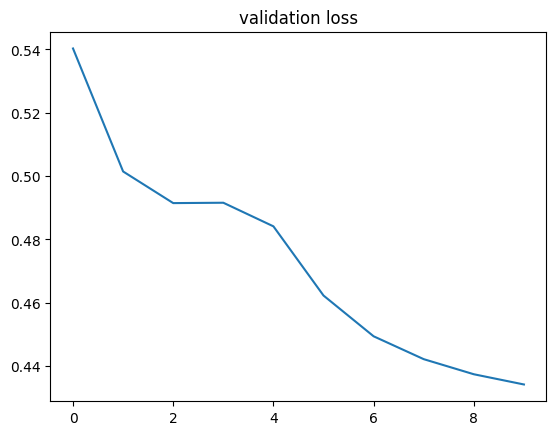

In [32]:
plt.plot(range(num_epochs),val_los_list)
plt.title('validation loss')

**test data prediction and comparing predicted values with the actual values**

Test loss: 0.4566


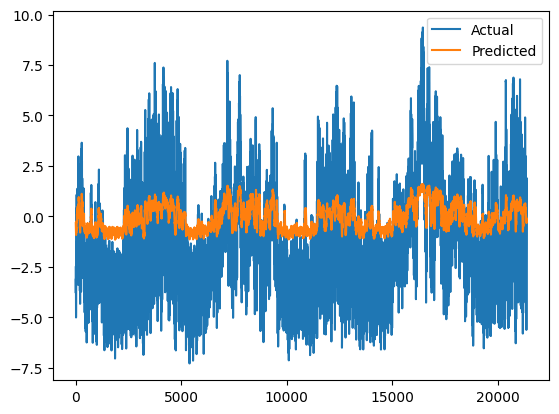

In [24]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler() 
with torch.no_grad():
    model1.eval()
    #test_input = torch.from_numpy(test_data[:, :-1]).float()   x_test
    #test_target = torch.from_numpy(test_data[:, -1]).float()   y_test
    output = model1(x_test)
    loss = criterion(output, y_test)
    output = scaler.fit_transform(output)
    predicted = scaler.inverse_transform(output)#.detach().numpy())
    actual = scaler.inverse_transform(y_test.detach().numpy().reshape(-1, 1))
    print(f"Test loss: {loss.item():.4f}")
    plt.plot(actual, label='Actual')
    plt.plot(predicted, label='Predicted')
    plt.legend()
    plt.show()

In [ ]:
actual[2]

array([-1.9977314], dtype=float32)

In [ ]:
predicted[2]

array([-0.63439739])

**calculating the perfomance metrics**

In [25]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def calculate_metrics(true, preds):
    #true, preds = df
    result_metrics = {'mae' : mean_absolute_error(true, preds),
                      'rmse' : mean_squared_error(true, preds) ** 0.5,
                      'r2' : r2_score(true, preds)}
    
    print("Mean Absolute Error:       ", result_metrics["mae"])
    print("Root Mean Squared Error:   ", result_metrics["rmse"])
    print("R^2 Score:                 ", result_metrics["r2"])
    return result_metrics

In [26]:
print(calculate_metrics(actual, predicted))

Mean Absolute Error:        2.169836564704385
Root Mean Squared Error:    2.6202700018605825
R^2 Score:                  0.10862865102629382
{'mae': 2.169836564704385, 'rmse': 2.6202700018605825, 'r2': 0.10862865102629382}


maybe underfit